 Установка зависимостей

In [81]:
!pip install scikit-learn
!pip install pandas
!pip install optuna
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Импорты сторонних библиотек

In [82]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import optuna as op
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Метрики

In [83]:
def cosineMetric(a: np.array, b: np.array):
    return 1 - np.dot(a, b) / (np.sqrt(np.dot(a, a)) * np.sqrt(np.dot(b, b)))


def euclideanMetric(a: np.array, b: np.array):
    return np.sqrt(np.sum((a - b) ** 2))


def manhattanMetric(a: np.array, b: np.array):
    return np.max(np.abs(a - b))

Ядра

In [84]:
def uniform(u: np.array):
    return (np.float64(0.5) * u) * (np.abs(u) < 1.0)


def triangular(u: np.array):
    return (1 - np.abs(u)) * (np.abs(u) < 1.0)


def epanechnikov(u: np.array):
    return (3 / 4 * (1 - u ** 2)) * (np.abs(u) < 1.0)


def gaussian(u: np.array):
    return 1.0 / np.sqrt(2.0 * np.pi) * np.exp((u ** 2) / -2.0)

Моделька

In [85]:
class kNNTreeLab:
    def __init__(self, metrics: callable, window: str):
        self.NN = NearestNeighbors(metric=metrics)
        if window not in ['fixed', 'mutable']:
            raise RuntimeError('window must be fixed or mutable')
        self.window = window
        self.objects = None
        self.probability = {}

    def fit(self, X: np.ndarray, Y: np.array):
        if len(X) != len(Y):
            raise RuntimeError('X and Y must have the same len')
        self.objects = Y
        self.NN.fit(X)

    def predict_one(self, x_in, kernel: callable, weights: np.ndarray = None, radius: int = None,
                    n_neighbors: int = None):
        if weights is None:
            weights = np.ones(len(self.objects))
        x = [x_in]
        if self.window == 'fixed':
            if radius is None:
                raise RuntimeError('radius must be specified')
            divisor = radius
            if kernel == gaussian:
                radius = np.inf
            neigh_dist, neigh_index = self.NN.radius_neighbors(x, radius, return_distance=True)
            neigh_index = neigh_index[0]
            neigh_dist = neigh_dist[0]
            if len(neigh_dist) == 0:
                raise RuntimeError('Too small radius')
        elif self.window == 'mutable':
            if n_neighbors is None:
                raise RuntimeError('n_neighbors must be specified')
            neigh_dist, neigh_index = self.NN.kneighbors(x, n_neighbors + 1, return_distance=True)
            neigh_index = neigh_index[0][:-1]
            neigh_dist = neigh_dist[0]
            divisor = neigh_dist[-1]
            neigh_dist = neigh_dist[:-1]
        else:
            raise RuntimeError('window must be fixed or mutable')
        modified_dist = kernel(neigh_dist / divisor) * weights[neigh_index]
        classes = self.objects[neigh_index]
        class_count_map = {}
        for i in range(len(classes)):
            if classes[i] not in class_count_map:
                class_count_map[classes[i]] = 0
            class_count_map[classes[i]] += modified_dist[i]
        sum_dist = sum(modified_dist)
        self.probability = dict(map(lambda x: (x[0], x[1]/sum_dist), class_count_map.items()))            
        return sorted(class_count_map.items(), key=lambda v: v[1], reverse=True)[0][0]

    def predict(self, x_in, kernel: callable, weights: np.ndarray = None, radius: int = None, n_neighbors: int = None):
        return list(map(lambda x: self.predict_one(x, kernel, weights, radius, n_neighbors), x_in))

    def get_prob(self):
        return self.probability

Dataset

<Axes: >

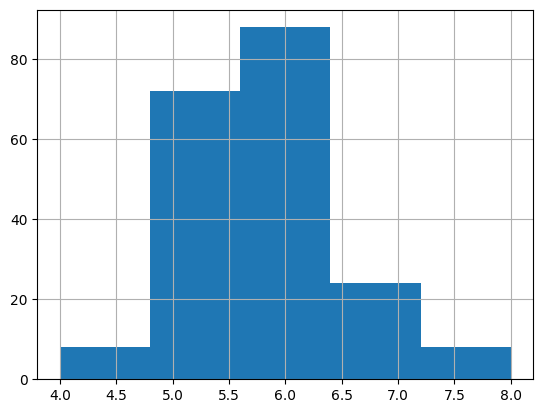

In [86]:
df = pd.read_csv("winequality-white.csv", sep=';')[:200]
criteria = df['quality']
scaler = StandardScaler()
data = scaler.fit_transform(df.drop(columns=['quality']).to_numpy())
X_train, X_test, y_train, y_test = train_test_split(data, criteria.to_numpy(), test_size=0.25, random_state=42)
df['quality'].hist(bins=5)

In [87]:
def opt_my_method(trial: op.Trial):
    Z_train, Z_test, w_train, w_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    window = trial.suggest_categorical('window-format', ['mutable', 'fixed'])
    metrics = trial.suggest_categorical('metrics', ['euclidean', 'cosine', 'manhattan'])
    if metrics == 'euclidean':
        metric = euclideanMetric
    elif metrics == 'cosine':
        metric = cosineMetric
    elif metrics == 'manhattan':
        metric = manhattanMetric
    else:
        raise RuntimeError("Metric {} not recognized".format(metrics))
    kernel = trial.suggest_categorical('kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    if kernel == 'uniform':
        kernel = uniform
    elif kernel == 'triangular':
        kernel = triangular
    elif kernel == 'epanechnikov':
        kernel = epanechnikov
    elif kernel == 'gaussian':
        kernel = gaussian
    else:
        raise RuntimeError("Kernel {} not recognized".format(kernel))
    model = kNNTreeLab(metric, window)
    model.fit(Z_train, w_train)
    if window == 'mutable':
        neighbors = trial.suggest_int('neighbors', 2, 20)
        res = model.predict(Z_test, kernel, n_neighbors=neighbors)
    elif window == 'fixed':
        radius = trial.suggest_float('radius', 1e-5, 2)
        res = model.predict(Z_test, kernel, radius=radius)
    else:
        raise RuntimeError("Window {} not recognized".format(window))
    return balanced_accuracy_score(w_test, res)


In [88]:
need_to_be_trained = False
if need_to_be_trained:
    study = op.create_study(direction='maximize')
    study.optimize(opt_my_method, n_jobs=-1, timeout=600, show_progress_bar=True, gc_after_trial=True,
                   catch=RuntimeError)
if need_to_be_trained:
    with open('best_param.txt', 'w') as f:
        f.write(str(study.best_params) + '\n')
        f.write(str(study.best_value))
with open('best_param.txt', 'r') as f:
    print(f.read())

{'window-format': 'mutable', 'metrics': 'manhattan', 'kernel': 'triangular', 'neighbors': 12}
0.768814192343604


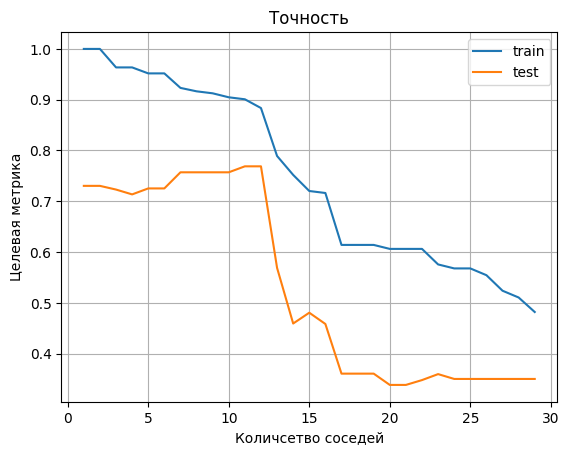

In [89]:
neigh = []
score_train = []
score_test = []
model = kNNTreeLab(manhattanMetric, 'mutable')
model.fit(X_train, y_train)
for i in range(1, 30):
    res = model.predict(X_test, triangular, n_neighbors=i)
    score_test.append(balanced_accuracy_score(y_test, res))
    res = model.predict(X_train, triangular, n_neighbors=i)
    score_train.append(balanced_accuracy_score(y_train, res))
    neigh.append(i)
plt.plot(neigh, score_train)
plt.plot(neigh, score_test)
plt.grid(True)
plt.title('Точность')
plt.xlabel('Количсетво соседей')
plt.ylabel('Целевая метрика')
plt.legend(['train', 'test'])
plt.show()

LOWESS

In [90]:
model = kNNTreeLab(manhattanMetric, 'mutable')
weights = []
for i in range(len(X_train)):
    new_x_test = X_train[i]
    new_y_test = y_train[i]
    new_x_train = np.delete(X_train, i, axis=0)
    new_y_train = np.delete(y_train, i, axis=0)
    model.fit(new_x_train, new_y_train)
    res = model.predict_one(new_x_test, triangular, n_neighbors=12)
    error_coef = model.get_prob().get(new_y_test, 0.0)
    weights.append(error_coef)
weights_g = gaussian(np.array(weights))
weights_u = uniform(np.array(weights))
model.fit(X_train, y_train)
res = model.predict(X_test, triangular, n_neighbors=12)
print("Ones", balanced_accuracy_score(y_test,  res))
res = model.predict(X_test, triangular, n_neighbors=12, weights=weights_g)
print("Gaussian", balanced_accuracy_score(y_test,  res))
res = model.predict(X_test, triangular, n_neighbors=12, weights=weights_u)
print("Uniform", balanced_accuracy_score(y_test,  res))

Ones 0.768814192343604
Gaussian 0.7548085901027077
Uniform 0.30662931839402424


Библиотечный алгоритм

In [91]:
from sklearn.neighbors import KNeighborsClassifier

In [92]:
def opt_my_method(trial: op.Trial) :
    Z_train, Z_test, w_train, w_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    metrics = trial.suggest_categorical('metrics', ['euclidean', 'cosine', 'manhattan'])
    if metrics == 'euclidean':
        metric = euclideanMetric
    elif metrics == 'cosine':
        metric = cosineMetric
    elif metrics == 'manhattan':
        metric = manhattanMetric
    else:
        raise RuntimeError("Metric {} not recognized".format(metrics))
    neighbors = trial.suggest_int('neighbors', 2, 20)
    model =  KNeighborsClassifier(n_neighbors=neighbors, metric=metric)
    model.fit(Z_train, w_train)
    res = model.predict(Z_test)
    return balanced_accuracy_score(w_test, res)


In [93]:
need_to_be_trained = False
if need_to_be_trained:
    study = op.create_study(direction='maximize')
    study.optimize(opt_my_method, n_jobs=-1, show_progress_bar=True, gc_after_trial=True,
                   catch=RuntimeError, n_trials=1000)
if need_to_be_trained:
    with open('best_param_lib.txt', 'w') as f:
        f.write(str(study.best_params) + '\n')
        f.write(str(study.best_value))
with open('best_param_lib.txt', 'r') as f:
    print(f.read())

{'metrics': 'cosine', 'neighbors': 11}
0.41666666666666663


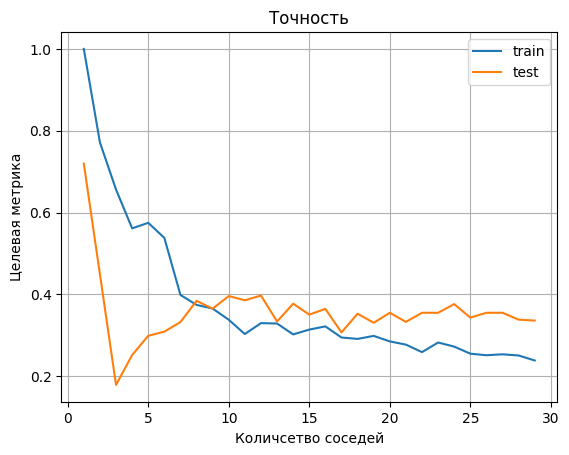

In [94]:
neigh = []
score_train = []
score_test = []
for i in range(1, 30):
    model = KNeighborsClassifier(metric=cosineMetric, n_neighbors=i)
    model.fit(X_train, y_train)
    res = model.predict(X_test)
    score_test.append(balanced_accuracy_score(y_test, res))
    res = model.predict(X_train)
    score_train.append(balanced_accuracy_score(y_train, res))
    neigh.append(i)
plt.plot(neigh, score_train)
plt.plot(neigh, score_test)
plt.grid(True)
plt.title('Точность')
plt.xlabel('Количсетво соседей')
plt.ylabel('Целевая метрика')
plt.legend(['train', 'test'])
plt.show()

In [95]:
model =  KNeighborsClassifier(n_neighbors=11, metric=cosineMetric)
weights = []
min_class = np.unique(y_train)[0]
for i in range(len(X_train)):
    new_x_test = X_train[i]
    new_y_test = y_train[i]
    new_x_train = np.delete(X_train, i, axis=0)
    new_y_train = np.delete(y_train, i, axis=0)
    model.fit(new_x_train, new_y_train)
    res = model.predict_proba([new_x_test])[0]
    error_coef = res[new_y_test- min_class]
    weights.append(error_coef)
weights = np.array(weights)

In [96]:
def opt_my_LOWESS(trial: op.Trial) :
    kernel = trial.suggest_categorical('kernel', ['uniform', 'triangular', 'epanechnikov', 'gaussian'])
    if kernel == 'uniform':
        kernel = uniform
    elif kernel == 'triangular':
        kernel = triangular
    elif kernel == 'epanechnikov':
        kernel = epanechnikov
    elif kernel == 'gaussian':
        kernel = gaussian
    else:
        raise RuntimeError("Kernel {} not recognized".format(kernel))
    tmp_weight = kernel(weights)
    bad_percintel = trial.suggest_float('percintel', 1e-3, 0.3)
    drop = []
    for it in range(len(tmp_weight)):
        if tmp_weight[it] <= bad_percintel:
            drop.append(it)
    tmp_x_train = np.delete(X_train, drop, axis=0)
    tmp_y_train = np.delete(y_train, drop, axis=0)
    model =  KNeighborsClassifier(n_neighbors=11, metric=cosineMetric)
    model.fit(tmp_x_train, tmp_y_train)
    res = model.predict(X_test)
    return balanced_accuracy_score(y_test, res)
            
study = op.create_study(direction='maximize')
study.optimize(opt_my_LOWESS, n_jobs=-1, show_progress_bar=True, gc_after_trial=True, n_trials=600)

[I 2024-03-12 21:43:45,484] A new study created in memory with name: no-name-f1106916-e964-42f0-baf6-d98a58671663


  0%|          | 0/600 [00:00<?, ?it/s]

[I 2024-03-12 21:43:45,594] Trial 1 finished with value: 0.23137254901960783 and parameters: {'kernel': 'uniform', 'percintel': 0.29293680352944995}. Best is trial 1 with value: 0.23137254901960783.
[I 2024-03-12 21:43:46,138] Trial 7 finished with value: 0.23137254901960783 and parameters: {'kernel': 'uniform', 'percintel': 0.27039189223597054}. Best is trial 1 with value: 0.23137254901960783.
[I 2024-03-12 21:43:46,671] Trial 8 finished with value: 0.34248366013071896 and parameters: {'kernel': 'uniform', 'percintel': 0.17641761531018962}. Best is trial 8 with value: 0.34248366013071896.
[I 2024-03-12 21:43:46,843] Trial 5 finished with value: 0.34248366013071896 and parameters: {'kernel': 'uniform', 'percintel': 0.169400446295518}. Best is trial 8 with value: 0.34248366013071896.
[I 2024-03-12 21:43:47,045] Trial 14 finished with value: 0.23137254901960783 and parameters: {'kernel': 'uniform', 'percintel': 0.2943241924809999}. Best is trial 8 with value: 0.34248366013071896.
[I 2024

In [97]:
model.fit(X_train, y_train)
res = model.predict(X_test)
print("Ones", balanced_accuracy_score(y_test,  res))
print("Best founded: " + str(study.best_params) + " with value: " + str(study.best_value))

Ones 0.38562091503267976
Best founded: {'kernel': 'triangular', 'percintel': 0.10607606364243728} with value: 0.38562091503267976
